# Solar Flux Analysis

I was doing some analysis that required evaluating a LEO satellite's lifetime - how long will it be before it reenters? This is to assess compliance with the IADC recommended guidelines for a reentry (or active deorbit) within 25 years [[1]](#ref_1). The orbital decay rate for a passive reentry due to atmospheric drag is driven by the area-to-mass ratio $A/m$ and the atmospheric density. The various atmospheric density models all use some measure of the predicted solar flux information to calculate the density. So we'll need this information looking forward at least 25 years (and likely more if you are evaluating for a launch that might not occur for 5 or more years). Predicting what the sun will be doing this far in future is whole other field of scientific expertise, tea leaf reading, and informed speculation and/or extrapolation. Check out [[2]](#ref_2), [[3]](#ref_3), and [[5]](#ref_5) for a review of the challenges around this and a comparison of various predictions. The short version is that the sun experiences a typical 11-year solar cycle, but the details of each cycle can vary (highest point, when it starts, etc.). The details behind this are best left to the heliophysics scientists.

For my purposes I wanted to run some of the "standard" models and see what range of lifetime answers I got. As usual, if you only run one tool you'll get one answer and probably be happy. When you run multiple tools you get multiple answers and have the burden of reconciling them. Tools use different density models, different integration schemes, etc. so I wasn't looking for exact matches - but rough "in the ballpark" agreement. Unfortunately I saw significant differences that I wasn't comfortable with. Depending on the tool and the space weather data files it uses I was getting wildly different answers - from reentering in 20 years to reentering in 100 years.

The primary driver for the density models is the Sun's solar flux values, typically referred to as the F10.7 (flux measured at the 10.7 cm wavelength). So I started digging into the solar flux data used by each tool to drive its density model and found some interesting results. I walk through each of the data sets below.

For this initial analysis I've downloaded the files from each source on 3 Aug 2021 and stored them locally so I can capture a snapshot in time. I expect that based on these results a few of the files may get updated to improve things. When that happens I'll revisit these results.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.rcParams.update({'font.family':'Gudea'})

## NASA's Debris Assessment Software (DAS)

NASA's Orbital Debris Office at Johnson Spaceflight Center (JSC) publishes a tool called DAS https://orbitaldebris.jsc.nasa.gov/mitigation/debris-assessment-software.html. One of it's capabilities is to estimate the spacecraft lifetime. It uses a solar flux table published by JSC at https://orbitaldebris.jsc.nasa.gov/library/das/solarflux_table.txt. We can grab it, parse it, and see that the file contains data from 1956-2150.

In [2]:
# Comment/uncomment the source you want to use.

src = 'https://orbitaldebris.jsc.nasa.gov/library/das/solarflux_table.txt'
src = '2021-08-03/solarflux_table.txt'

das_df = pd.read_csv(src, sep='\s+', skiprows=5, header=None, index_col=False, parse_dates={'date': [2, 3, 4]}, 
                     names=['JDate', 'F10.7', 'year', 'month', 'day'])
das_df.set_index('date', inplace=True)
das_df.iloc[[0, -1]]

,JDate,F10.7
date,,
1956-12-31,2435839.0,258.63
2150-06-30,2506512.0,79.97


## AGI's Solar Flux Data

AGI's System Tool Kit (STK) software has a Lifetime tool. It uses a solar flux file generated by AGI ftp://ftp.agi.com/pub/DynamicEarthData/SolFlx_CSSI.dat using algorithms developed by Dave Vallado and TS Kelso (formerly of AGI's Center for Space Standards and Innovation (CSSI), and now with the Commercial Space Operations Center (COMSPOC) - note that TS has since retired but continues to run the Celestrak.org website). See [[3]](#ref_3) for their paper that discusses the methodology for generating the predicted data. Grabbing the file and parsing it we see the file contains data from 2017 to 2043. This file is only meant to be used for lifetime predictions, so the start date continues to move to the left when AGI periodically updates the file.

In [3]:
# Comment/uncomment the source you want to use.

src = 'ftp://ftp.agi.com/pub/DynamicEarthData/SolFlx_CSSI.dat'
src = '2021-08-03/SolFlx_CSSI.dat'

cssi_df = pd.read_csv(src, sep='\s+', skiprows=1, header=None, index_col=False, names=['year', 'month', 'F10.7+2', 'F10.7', 'Ap+2', 'Ap'])

# The data is monthly, so we'll force the date to be mid-month (per a conversation with Dave Vallado)

cssi_df['day'] = 15
cssi_df['date'] = pd.to_datetime(cssi_df[['year', 'month', 'day']])
cssi_df.set_index('date', inplace=True)
cssi_df.drop('day', axis=1, inplace=True)
cssi_df.iloc[[0, -1]]

,year,month,F10.7+2,F10.7,Ap+2,Ap
date,,,,,,
2017-01-15,2017,1,98.40,88.67,12,12
2043-03-15,2043,3,70.97,69.95,10,10


AGI also has a more detailed space weather file ftp://ftp.agi.com/pub/DynamicEarthData/SpaceWeather-All-v1.2.txt that contains the historical solar flux and geomagnetic values at much finer time resolution. It's used for operational flight dynamics (e.g. what's going on in the next 3 to 30 days). It also has some of the predicted values as well. This file isn't normally used for lifetime analysis (for reasons that will be evident later on). The file contains data from 1957-2044.

In [4]:
spaceweather_cols = ['year', 'month', 'day', 'bartels_num', 'bartels_day', 'Kp_0000', 'Kp_0300', 'Kp_0600', 'Kp_0900', 'Kp_1200', 'Kp_1500', 'Kp_1800', 'Kp_2100',
                    'Kp_sum', 'Ap_0000', 'Ap_0300', 'Ap_0600', 'Ap_0900', 'Ap_1200', 'Ap_1500', 'Ap_1800', 'Ap_2100', 'Ap_avg', 'Cp', 'C9', 'ISN', 'F10.7_adj',
                    'F10.7_qual', 'F10.7_adj_center_81', 'F10.7_adj_last_81', 'F10.7_obs', 'F10.7_obs_center_81', 'F10.7_obs_last_81']

# Get the AGI space weather file that is used in STK and ODTK
# Comment/uncomment the source you want to use.

src = 'ftp://ftp.agi.com/pub/DynamicEarthData/SpaceWeather-All-v1.2.txt'
src = '2021-08-03/SpaceWeather-All-v1.2.txt'

agi_df = pd.read_csv(src, sep='\s+', skiprows=19, header=None, index_col=False, low_memory=False, names=spaceweather_cols)

# We know that the file contains various non-numeric keywords
# that are marked as NaN in the dataframe.

agi_df.dropna(inplace=True)

# Build a date field 
agi_df['date'] = pd.to_datetime(agi_df[['year', 'month', 'day']])

# it's important to drop the duplicates because there are multiple entries in the predict portions because
# of the different methods used to generate them.

agi_df.drop_duplicates('date', keep='first', inplace=True)
agi_df.set_index('date', inplace=True)
agi_df.iloc[[0, -1]]

,year,month,day,bartels_num,bartels_day,Kp_0000,Kp_0300,Kp_0600,Kp_0900,Kp_1200,...,Cp,C9,ISN,F10.7_adj,F10.7_qual,F10.7_adj_center_81,F10.7_adj_last_81,F10.7_obs,F10.7_obs_center_81,F10.7_obs_last_81
date,,,,,,,,,,,,,,,,,,,,,
1957-10-01,1957,10,01,1700.0,19.0,43.0,40.0,30.0,20.0,37.0,...,1.1,5.0,236.0,268.0,0.0,265.2,230.6,269.3,266.6,230.9
2044-06-01,2044,06,01,2873.0,3.0,22.0,22.0,22.0,22.0,22.0,...,0.4,2.0,6.0,67.9,0.0,67.9,67.9,66.0,66.6,67.8


# Celestrak Space Weather

At the Celestrak site www.celestrak.org Dr. TS Kelso also publishes a consolidated space weather file http://celestrak.org/SpaceData/SW-Last5Years.txt. It's the same format as the AGI space weather file (for quite a few years they were the same as TS was working for AGI). One minor difference worth noting is that in the predicted portions of the file TS leaves the columns blank (it's a column delimited format). The AGI version populates all the columns (so read_csv works for the AGI file but not the Celestrak one). Pulling that data in we find a range from 2016 to 2032.

In [5]:
# Comment/uncomment the source you want to use.

src = 'http://celestrak.org/SpaceData/SW-Last5Years.txt'
src = '2021-08-03/SW-Last5Years.txt'

celestrak_df = pd.read_fwf(src, sep='\s+', skiprows=19, header=None, index_col=False, colspecs='infer')
celestrak_df.columns = spaceweather_cols

# Force year to be numeric to flag the non-numeric values as NaN and then drop them. 
# This gets rid of the rows containing keywords and not values.

celestrak_df['year'] = pd.to_numeric(celestrak_df['year'], errors='coerce')
celestrak_df.dropna(subset=['year'], inplace=True)

# Build a date field 
celestrak_df['date'] = pd.to_datetime(celestrak_df[['year', 'month', 'day']])
celestrak_df.set_index('date', inplace=True)
celestrak_df.iloc[[0, -1]]

,year,month,day,bartels_num,bartels_day,Kp_0000,Kp_0300,Kp_0600,Kp_0900,Kp_1200,...,Cp,C9,ISN,F10.7_adj,F10.7_qual,F10.7_adj_center_81,F10.7_adj_last_81,F10.7_obs,F10.7_obs_center_81,F10.7_obs_last_81
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,2016.0,01,01,2488,19,60,53,50,33.0,17,...,1.2,6.0,37.0,95.1,0.0,105.2,109.0,100.0,108.4,111.5
2032-01-01,2032.0,01,01,2705,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,217.9,NaN,0.0,0.0,225.4,0.0,0.0


## NOAA Solar Flux Predictions

NOAA's Space Weather Prediction Center (SWPC) https://www.swpc.noaa.gov/ publishes solar flux predictions as well. You can get a nice interactive graph at https://www.swpc.noaa.gov/products/solar-cycle-progression and see their projections up through 2033. Click on the "Data" tab to see the links for the file below. The file contains data from 2021 to 2040.

In [6]:
# Comment/uncomment the source you want to use.

src = 'https://services.swpc.noaa.gov/json/solar-cycle/predicted-solar-cycle.json'
src = '2021-08-03/predicted-solar-cycle.json'

noaa_df = pd.read_json(src)
noaa_df[['year', 'month']] = noaa_df['time-tag'].str.split('-', expand=True)
noaa_df['day'] = 15
noaa_df['date'] = pd.to_datetime(noaa_df[['year', 'month', 'day']])
noaa_df.set_index('date', inplace=True)
noaa_df.drop(['year', 'month', 'day'], axis=1, inplace=True)
noaa_df.iloc[[0, -1]]

,time-tag,predicted_ssn,high_ssn,low_ssn,predicted_f10.7,high_f10.7,low_f10.7
date,,,,,,,
2021-02-15,2021-02,18.9,19.9,17.9,77.90,78.9,76.9
2040-12-15,2040-12,0.0,9.0,0.0,67.73,8.0,67.7


# Other Files

There are other sources of predicted solar flux data that I would have liked to analyze as well but couldn't find samples to use. If you have some let me know and I'll add them to the document.

* Schatten predicted values - these are produced by NASA's Goddard Space Flight Center (GSFC). They used to be available at the GSFC FTP site, but this site no longer exists as NASA has been eliminating the use of FTP as part of an overall process to improve their cybersecurity. Further, there was a point 5-7 years ago when someone at GSFC was questioning whether AGI could use and redistribute the Schatten files because someone else thought they might be considered Export controlled. AGI couldn't get a clear answer on whether they were Controlled Unclassified Information (CUI) so they took the safe route and stopped using it and had the CSSI team start generating their own predicts.
* GMAT - The GMAT documentation (http://gmat.sourceforge.net/docs/R2018a/help.html) indicates that they use the AGI Space Weather file for historical data and the Schatten file for predicted data. The Schatten file is apparently available from the GSFC Flight Dynamics Facility but the URL provided in the help is not valid. 
* FreeFlyer - The FreeFlyer documentation (https://ai-solutions.com/_help_Files/schatten_solar_flux_files.htm) indicates they they also use the Schatten files, but no indication as to where to get them from.
* Space Environment Technologies - SET http://spacenvironment.net publishes updated solar flux data (using E10.7, not F10.7 if I recall correctly) for use in the Jacchia-Bowman 2008 density model. Unfortunately I haven't been able to successfully download anything from them (URL's aren't working even after logging in). Let me know if you have some of this data.
* US Air Force (now Space Force) - I haven't found a direct source for their predictions, but NOAA's SWPC redistributes a 45 day prediction file at https://www.swpc.noaa.gov/products/usaf-45-day-ap-and-f107cm-flux-forecast. Since it only covers 45 days I didn't bother analyzing it. Let me know if you'd like to see this. 

Since both GMAT and FreeFlyer use the Schatten files it suggests that they are not CUI. None the less they are apparently difficult to obtain. If anyone knows a current source please let me know and I'll add them in.

# What did we end up with?

Let's plot the F10.7 values to see how they trend over time.

In [7]:
def plot_flux(start, stop, das_df, agi_df, cssi_df, noaa_df, celestrak_df, window25=None):
    
    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot()
    
    if das_df is not None:
        span = das_df[start:stop]
        ax.plot_date(x=span.index, y=span['F10.7'], color='black', linestyle=(0, (5, 5)), linewidth=1, marker=None, label='NASA DAS')
       
    if cssi_df is not None:
        span = cssi_df[start:stop]
        ax.plot_date(x=span.index, y=span['F10.7'], color='black', linestyle='-', linewidth=2, marker=None, label='CSSI')

    if noaa_df is not None:
        span = noaa_df[start:stop]        
        ax.plot_date(x=span.index, y=span['predicted_f10.7'], color='mediumblue', linestyle='-', linewidth=2, marker='None', label='NOAA SWPC')
    
    if agi_df is not None:
        span = agi_df[start:stop]
        ax.plot_date(x=span.index, y=span['F10.7_obs'], color='red', linestyle='dotted', linewidth=2, marker=None, label='AGI')

    if celestrak_df is not None:
        span = celestrak_df[start:stop]
        ax.plot_date(x=span.index, y=span['F10.7_obs'], color='red', linestyle=(0, (5, 5)), linewidth=1, marker=None, label='Celestrak')    
        
    # should we show the 25-year lifetime window?
    if window25:
        window_start = pd.to_datetime(window25)
        window_delta = pd.Timedelta(25*365, 'D')
        ax.add_patch(Rectangle((window_start, 55), window_delta, 5, color="lightblue"))
        ax.annotate("25 Year Window", xy=(window_start + 0.5*window_delta, 55), horizontalalignment='center',
                    fontsize=12)
        
    # make the graph look nice
    ax.set_xlabel('Date')
    ax.set_ylabel('F10.7')
    ax.set_ylim(ymin=50)
    ax.legend(frameon=False, loc='upper left', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title('Predicted Solar Flux (F10.7) Values',fontsize=14)
    
    # add some solar cycle references at 11 year periods
    cycles = pd.date_range('2025-01-01', stop, freq='11A-JAN')
    for i, cycle_date in enumerate(cycles):
        cycle = 25+i
        ax.annotate(f"Cycle {cycle}", xy=(cycle_date, 100), fontsize=12, horizontalalignment='center')


Let's start with just the next 5 years - so through Aug 2026. Four of the sources show a similar trend, rising nicely as we enter solar cycle 25. The NOAA SWPC and NASA DAS values line up exactly on top of each other (which is why it looks like there's only three lines instead of four). If you dig into the data you'll see that the CSSI and NOAA SWPC values are monthly but the NASA DAS points are provided daily. The very nice agreement between the NASA DAS and NOAA SWPC values suggests the former is merely an interpolated version of the latter.

The Celestrak file shows a disturbing spike at the start of 2023. I've reached out to TS. Kelso to alert him and see if he can get to the bottom of it. 

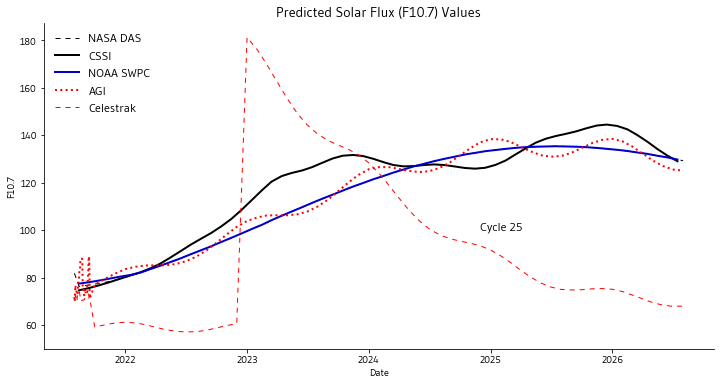

In [8]:
plot_flux('2021-08-01', '2026-08-01', das_df, agi_df, cssi_df, noaa_df, celestrak_df)

Now let's go out a bit further. Around 2032 we see the NASA DAS and CSSI values start to rise into solar cycle 26 as expected. But the NOAA SWPC and AGI data files don't - instead they flat line to around 68 and completely miss solar cycle 26. The AGI files were not meant for long term prediction, so this isn't surprising. The NASA DAS model predicts significantly higher flux values than the CSSI model. More on this later.

The NOAA SWPC data runs out at the end of 2040. The AGI data runs a bit longer but looks sort of wonky from 2041 on and running out of data in 2044. The AGI data oscillates around the NOAA SWPC data until it runs out (and the wonkiness begins).

The Celestrak data is quite off - as if there's a phase error in the algorithm.

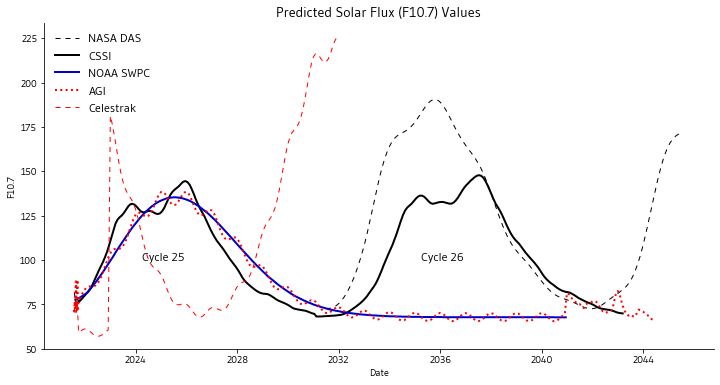

In [9]:
plot_flux('2021-08-01', '2045-08-01', das_df, agi_df, cssi_df, noaa_df, celestrak_df)

Looking out even further, we see that the NASA DAS model basically replicates the same cycle behavior over and over.

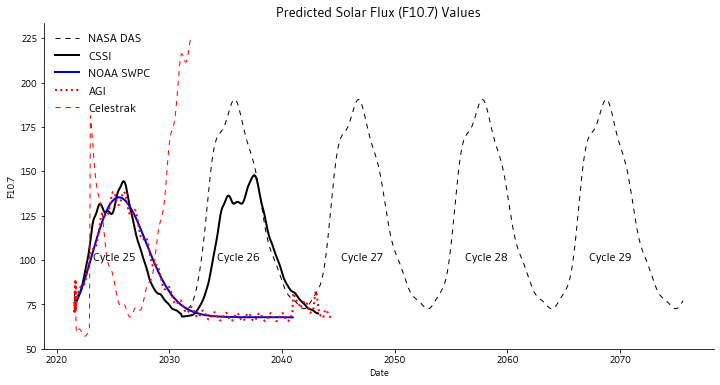

In [10]:
plot_flux('2021-08-01', '2075-08-01', das_df, agi_df, cssi_df, noaa_df, celestrak_df)

The question is whether the pattern that's being repeated by NASA DAS is appropriate. Looking back at the historical data sheds a little insight on this. The cycles before 25 certainly show higher peaks (if you squint your eyes and "smooth" the values). So at first glance it seems "reasonable" - meaning it's not so far off that I can argue there's something better (especially since I don't understand heliphysics ...). 

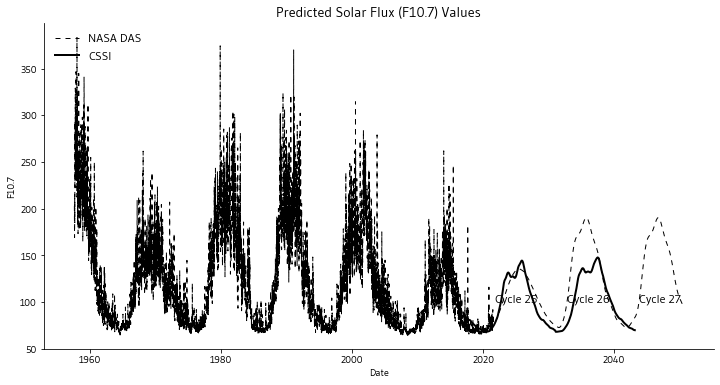

In [11]:
plot_flux('1957-08-01', '2050-08-01', das_df, None, cssi_df, None, None)

# Therefore What?

What's an engineer to do? If I'm trying to evaluate whether a spacecraft reaching end-of-mission in January, 2024 will meet the 25-year IADC guideline using a passive decay then I'm going to be very interested in how the atmosphere behaves from 2024-2049. Revisiting our plots over this range of data shows that I should not be using the NOAA SWPC or AGI SpaceWeather files for my predicts because they flat-lined. The AGI CSSI and NASA DAS files are both ok, but as we get past 2043 the AGI CSSI file runs out too. On the bright side, if you decay before 2044 using either file you should feel confident that you are ok. Even though the AGI CSSI values are starting to diverge from the NASA DAS in the 2043-2044 range, the true values are likely higher than the AGI CSSI values and your drag would be larger than predicted (thus causing you to reenter earlier).

If you don't decay by 2044, then it's a bit murkier and I'd have to go with the NASA DAS prediction (unless we can a longer predict for the AGI CSSI file).

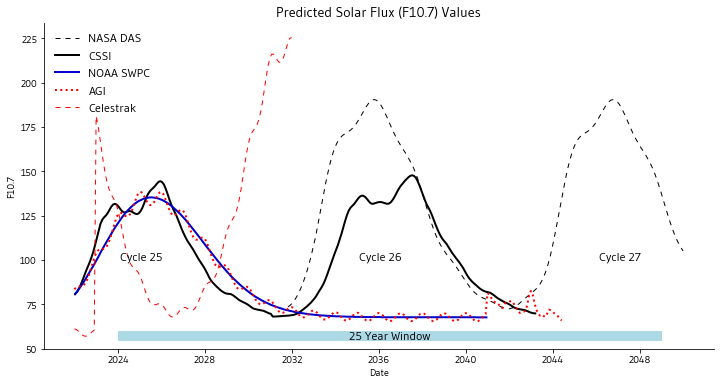

In [12]:
plot_flux('2022-01-01', '2050-01-01', das_df, agi_df, cssi_df, noaa_df, celestrak_df, window25='2024-01-01')

# References

<a id='ref_1'></a>
[1] "IADC Space Debris Guidelines", Revision 3, https://www.iadc-home.org/documents_public/index

<a id='ref_2'></a>
[2] Pesnell, W. "Predictions of Solar Cycle 24: How are we doing?". https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1002/2015SW001304

<a id='ref_3'></a>
[3] Pesnell, W. "Lessons learned from predictions of Solar Cycle 24". https://www.swsc-journal.org/articles/swsc/full_html/2020/01/swsc200057/swsc200057.html

<a id='ref_4'></a>
[4] Vallado, D. and Kelso, TS. "Using EOP and Space Weather Data for Operations", AAS 05-406. https://celestrak.com/publications/AAS/05-406/6USR-SSW-S7.2.pdf

<a id='ref_5'></a>
[5] Vallado, D. and Oltrogge, D. "Satellite Lifetime and Solar Cycle Predictions", 8th European Conference on Space Debris. https://conference.sdo.esoc.esa.int/proceedings/sdc8/paper/265/SDC8-paper265.pdf.

